### Import data

In [1]:
import pandas as pd
from tabulate import tabulate
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [2]:
# Path to the processed data
file_path = r"D:\INX_Future_Employee_Performance_Project\data\processed\prepared_data.csv"
# Load the data
data = pd.read_csv(file_path)

### Imports & functions

In [3]:
from insightfulpy.eda import *
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, 
    learning_curve, StratifiedKFold
)
from sklearn.utils import resample, compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve, auc, 
    classification_report, precision_recall_fscore_support
)
from sklearn.calibration import calibration_curve
import scikitplot as skplt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import shap
from tabulate import tabulate
import time
import os

In [4]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    import time
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.model_selection import StratifiedKFold, cross_val_score

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time  

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        except:
            roc_auc = None
    else:
        roc_auc = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1_metric = f1_score(y_test, y_pred, average='weighted')
    acc_train = accuracy_score(y_train, y_pred_train)
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring='f1_weighted').mean()
    overfit = acc_train - acc
    return {
        "Training Time (sec)": round(train_time, 3),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1_metric,
        "ROC AUC": roc_auc,
        "CV F1-Score": cv_f1,
        "Train Accuracy": acc_train,
        "Overfit (Train - Test Acc)": overfit
    }

def cross_validation_analysis_table(model, X_train, y_train, cv_folds=5, scoring_metric="f1_weighted"):
    """
    This function performs cross-validation on the given model and generates a table with the evaluation scores.
    """
    # Ensure y_train is the correct format (integer-encoded or categorical)
    if not np.issubdtype(y_train.dtype, np.integer):
        print("Warning: Target variable `y_train` should be integer-encoded for multiclass classification.")
    strat_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    # Perform cross-validation and calculate scores
    scores = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring=scoring_metric)
    
    # If the result is NaN, there might be an issue with the data or scoring metric
    if np.any(np.isnan(scores)):
        print(f"Error: Cross-validation resulted in NaN values. Please check the data and try with another scoring metric.")
        return None
    # Create a DataFrame to display the results
    cv_results_df = pd.DataFrame({
        "Fold": [f"Fold {i+1}" for i in range(cv_folds)],
        "F1-Score": scores
    })
    # Add Mean and Standard Deviation of scores
    cv_results_df.loc["Mean"] = ["Mean", np.mean(scores)]
    cv_results_df.loc["Std"] = ["Standard Deviation", np.std(scores)]
    return cv_results_df
    
def plot_multiclass_evaluation(model, X_test, y_test, class_labels=None):
    y_probs = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    if class_labels is None:
        class_labels = [f"Class {i}" for i in np.unique(y_test)]
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    try:
        roc_auc = roc_auc_score(y_test, y_probs, multi_class="ovr", average="macro")
    except:
        roc_auc = None

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    # ROC Curve
    if roc_auc:
        skplt.metrics.plot_roc(y_test, y_probs, ax=axes[0, 0])
        axes[0, 0].set_title(f"ROC Curve (Macro AUC = {roc_auc:.3f})")
    else:
        axes[0, 0].text(0.5, 0.5, "ROC Curve not available", ha='center', va='center', fontsize=12)
        axes[0, 0].axis("off")
    # Precision-Recall Curve
    skplt.metrics.plot_precision_recall_curve(y_test, y_probs, ax=axes[0, 1])
    axes[0, 1].set_title("Precision-Recall Curve")
    # Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=axes[1, 0], cmap="Blues")
    axes[1, 0].set_title("Confusion Matrix")
    # Normalized Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_labels).plot(ax=axes[1, 1], cmap="Blues")
    axes[1, 1].set_title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

def mean_absolute_shap(shap_values):
    """Handle both binary and multiclass SHAP values"""
    if isinstance(shap_values, list):
        # Multiclass: list of arrays (classes × samples × features)
        return np.mean([np.abs(class_shap).mean(0) for class_shap in shap_values], axis=0)
    elif len(shap_values.shape) == 3:
        # Multiclass: single array (samples × features × classes)
        return np.abs(shap_values).mean(axis=(0, 2))  # Mean across samples and classes
    else:
        # Binary classification
        return np.abs(shap_values).mean(axis=0)

def cross_validation_analysis_table(model, X_train, y_train, cv_folds=5, scoring_metric="f1_weighted"):
    strat_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=strat_kfold, scoring=scoring_metric)   
    cv_results_df = pd.DataFrame({
        "Fold": [f"Fold {i+1}" for i in range(cv_folds)],
        "F1-Score": scores
    })
    # Append Mean and Standard Deviation
    cv_results_df.loc[len(cv_results_df)] = ["Mean", np.mean(scores)]
    cv_results_df.loc[len(cv_results_df)] = ["Standard Deviation", np.std(scores)]
    
    return cv_results_df

---

### Basic checks and understand the data

In [5]:
columns_info("Dataset Overview", data)


======== Dataset Overview: ===========

Index Col Index  Attribute                      Data Type       Range                          Distinct Count
----- ---------- ------------------------------ --------------- ------------------------------ ---------------
1     4          EmpDepartment_Development      bool            N/A                            2
2     5          EmpJobRole_freq                float64         0.0058333333333333 - 0.225     18
3     0          EmpLastSalaryHikePercent       int64           11 - 25                        15
4     1          EmpEnvironmentSatisfaction     int64           0 - 3                          4
5     2          YearsSinceLastPromotion        int64           0 - 10                         11
6     3          ExperienceYearsAtThisCompany   int64           0 - 20                         21
7     6          EmpWorkLifeBalance             int64           0 - 3                          4
8     7          OverTime                       int64  

In [6]:
print(data.shape)
for idx, col in enumerate(data.columns):
        print(f"{idx}: {col}")

(1200, 12)
0: EmpLastSalaryHikePercent
1: EmpEnvironmentSatisfaction
2: YearsSinceLastPromotion
3: ExperienceYearsAtThisCompany
4: EmpDepartment_Development
5: EmpJobRole_freq
6: EmpWorkLifeBalance
7: OverTime
8: EmpJobSatisfaction
9: TotalWorkExperienceInYears
10: DistanceFromHome
11: PerformanceRating


In [7]:
data.head().T

,0,1,2,3,4
EmpLastSalaryHikePercent,12,12,21,15,14
EmpEnvironmentSatisfaction,3,3,3,1,0
YearsSinceLastPromotion,0,1,1,10,2
ExperienceYearsAtThisCompany,10,7,18,20,2
EmpDepartment_Development,False,False,False,False,False
EmpJobRole_freq,0.225,0.225,0.225,0.0425,0.225
EmpWorkLifeBalance,1,2,2,1,2
OverTime,0,0,1,0,0
EmpJobSatisfaction,3,0,0,3,0
TotalWorkExperienceInYears,10,20,20,23,10


The final dataset contains 1,200 records and 12 features, including the target PerformanceRating. Key features include EmpLastSalaryHikePercent, EmpEnvironmentSatisfaction, and YearsSinceLastPromotion, all of which significantly impact employee performance. Features like EmpJobRole_freq and EmpDepartment_Development capture job-related variables, while EmpWorkLifeBalance and OverTime reflect work conditions. The dataset also includes ExperienceYearsAtThisCompany, TotalWorkExperienceInYears, and DistanceFromHome, which represent experience and commute factors. The data is clean, without missing or infinite values, and is ready for modeling.

# Model Development

---

### data spliting

In [8]:
# Split the full dataset (assuming `final_data` includes the features + target column)
X = data.drop(columns=['PerformanceRating'])
y = data['PerformanceRating']

# Map target labels from [1, 2, 3] → [0, 1, 2]
label_mapping = {1: 0, 2: 1, 3: 2}
y_mapped = y.map(label_mapping)

# Train-Test Split (Stratified to preserve class distribution)
X_train, X_test, y_train_mapped, y_test_mapped = train_test_split(
    X, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train_mapped.shape}, y_test: {y_test_mapped.shape}")

output_dir = r"D:\INX_Future_Employee_Performance_Project\data\processed"
os.makedirs(output_dir, exist_ok=True)

# Save splits
X_train.to_csv(os.path.join(output_dir, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(output_dir, "X_test.csv"), index=False)
y_train_mapped.to_csv(os.path.join(output_dir, "y_train.csv"), index=False)
y_test_mapped.to_csv(os.path.join(output_dir, "y_test.csv"), index=False)

X_train: (960, 11), X_test: (240, 11)
y_train: (960,), y_test: (240,)


In [9]:
classes = np.unique(y_train_mapped)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_mapped)
mapped_class_weights = dict(zip(classes, weights))
catboost_weights = list(weights)  # for CatBoost

In [10]:
mapped_class_weights

{0: 2.064516129032258, 1: 0.45779685264663805, 2: 3.018867924528302}

In [11]:
catboost_weights

[2.064516129032258, 0.45779685264663805, 3.018867924528302]

The dataset has been successfully split into training and testing sets, with 960 samples for training and 240 for testing. The target labels PerformanceRating (ranging from [1, 2, 3]) have been mapped to a new range of [0, 1, 2], to ensure compatibility with classification algorithms. The class distribution in the training set has been preserved through stratified sampling.

Class weights have been computed to address class imbalance, with the following weights for the classes:

Class 0 (lowest performance): 2.06

Class 1 (average performance): 0.46

Class 2 (highest performance): 3.02

These weights will be used in model training, particularly for CatBoost, to ensure the model is sensitive to class imbalances. The data is now prepared for the next stages of model training and evaluation.

### Model Training & Evaluation

In [12]:
classes = np.unique(y_train_mapped)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_mapped)
class_weights = dict(zip(classes, weights))

In [13]:
sample_weights = np.array([class_weights[label] for label in y_train_mapped])
final_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    subsample=0.9,
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train, y_train_mapped, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [14]:
final_result = evaluate_model(final_model, X_train, y_train_mapped, X_test, y_test_mapped)
final_df = pd.DataFrame([final_result], index=["Final XGBoost Model"])
final_df

,Training Time (sec),Accuracy,Precision,Recall,F1-Score,ROC AUC,CV F1-Score,Train Accuracy,Overfit (Train - Test Acc)
Final XGBoost Model,0.927,0.925,0.927002,0.925,0.924211,0.975572,0.933238,0.933333,0.008333


| Feature                      |   Tree-Based |   SHAP |
|:-----------------------------|-------------:|-------:|
| EmpEnvironmentSatisfaction   |       0.232  | 0.4945 |
| EmpLastSalaryHikePercent     |       0.225  | 0.372  |
| YearsSinceLastPromotion      |       0.2012 | 0.2631 |
| EmpWorkLifeBalance           |       0.0335 | 0.131  |
| EmpDepartment_Development    |       0.1405 | 0.1015 |
| ExperienceYearsAtThisCompany |       0.0513 | 0.0349 |
| EmpJobRole_freq              |       0.0177 | 0.0131 |
| DistanceFromHome             |       0.0291 | 0.0121 |
| EmpJobSatisfaction           |       0.0251 | 0.0087 |
| OverTime                     |       0.029  | 0.0028 |
| TotalWorkExperienceInYears   |       0.0156 | 0.0027 |


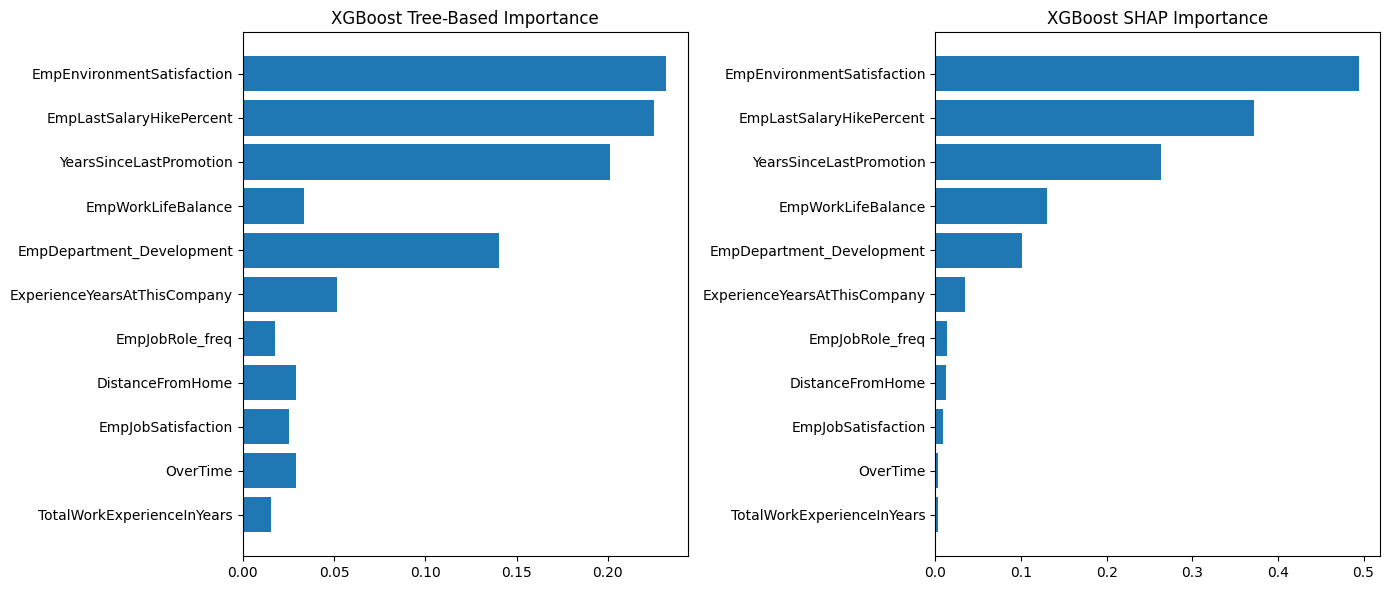

In [15]:
# Feature importance from tree splits
xgb_importance = final_model.feature_importances_
# SHAP importance (mean absolute value)
explainer_xgb = shap.TreeExplainer(final_model.get_booster())
xgb_shap = explainer_xgb.shap_values(X_train)
shap_importance = mean_absolute_shap(xgb_shap)
# Combine df
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Tree-Based": xgb_importance,
    "SHAP": shap_importance
}).sort_values("SHAP", ascending=False)
print(tabulate(importance_df.round(4), headers='keys', tablefmt='pipe', showindex=False))
# Subplot bar chart
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot
axs[0].barh(importance_df["Feature"], importance_df["Tree-Based"])
axs[0].set_title("XGBoost Tree-Based Importance")
axs[0].invert_yaxis()
axs[1].barh(importance_df["Feature"], importance_df["SHAP"])
axs[1].set_title("XGBoost SHAP Importance")
axs[1].invert_yaxis()
plt.tight_layout()
plt.show()

The XGBoost model places the highest importance on EmpEnvironmentSatisfaction and EmpLastSalaryHikePercent, with SHAP values of 0.4945 and 0.372, respectively. These features are considered highly influential by XGBoost. YearsSinceLastPromotion also ranks highly, contributing significantly to the prediction, with a value of 0.2631. On the other hand, features like EmpJobSatisfaction and TotalWorkExperienceInYears have low importance in XGBoost, with values of 0.0087 and 0.0027, respectively.

In [16]:
# Usage
cv_results_table = cross_validation_analysis_table(final_model, X_train, y_train_mapped, cv_folds=5)
# View results
print(cv_results_table)

                 Fold  F1-Score
0              Fold 1  0.936955
1              Fold 2  0.933230
2              Fold 3  0.926451
3              Fold 4  0.937101
4              Fold 5  0.932453
5                Mean  0.933238
6  Standard Deviation  0.003884


In [17]:
# Predict on test set
y_pred = final_model.predict(X_test)
# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test_mapped, y_pred, target_names=["Rating 1", "Rating 2", "Rating 3"]))
# Confusion Matrix
print(" Confusion Matrix (rows = Actual, columns = Predicted):\n")
cm = confusion_matrix(y_test_mapped, y_pred)
print(cm)


 Classification Report:

              precision    recall  f1-score   support

    Rating 1       0.82      0.85      0.84        39
    Rating 2       0.94      0.97      0.95       175
    Rating 3       1.00      0.77      0.87        26

    accuracy                           0.93       240
   macro avg       0.92      0.86      0.89       240
weighted avg       0.93      0.93      0.92       240

 Confusion Matrix (rows = Actual, columns = Predicted):

[[ 33   6   0]
 [  6 169   0]
 [  1   5  20]]


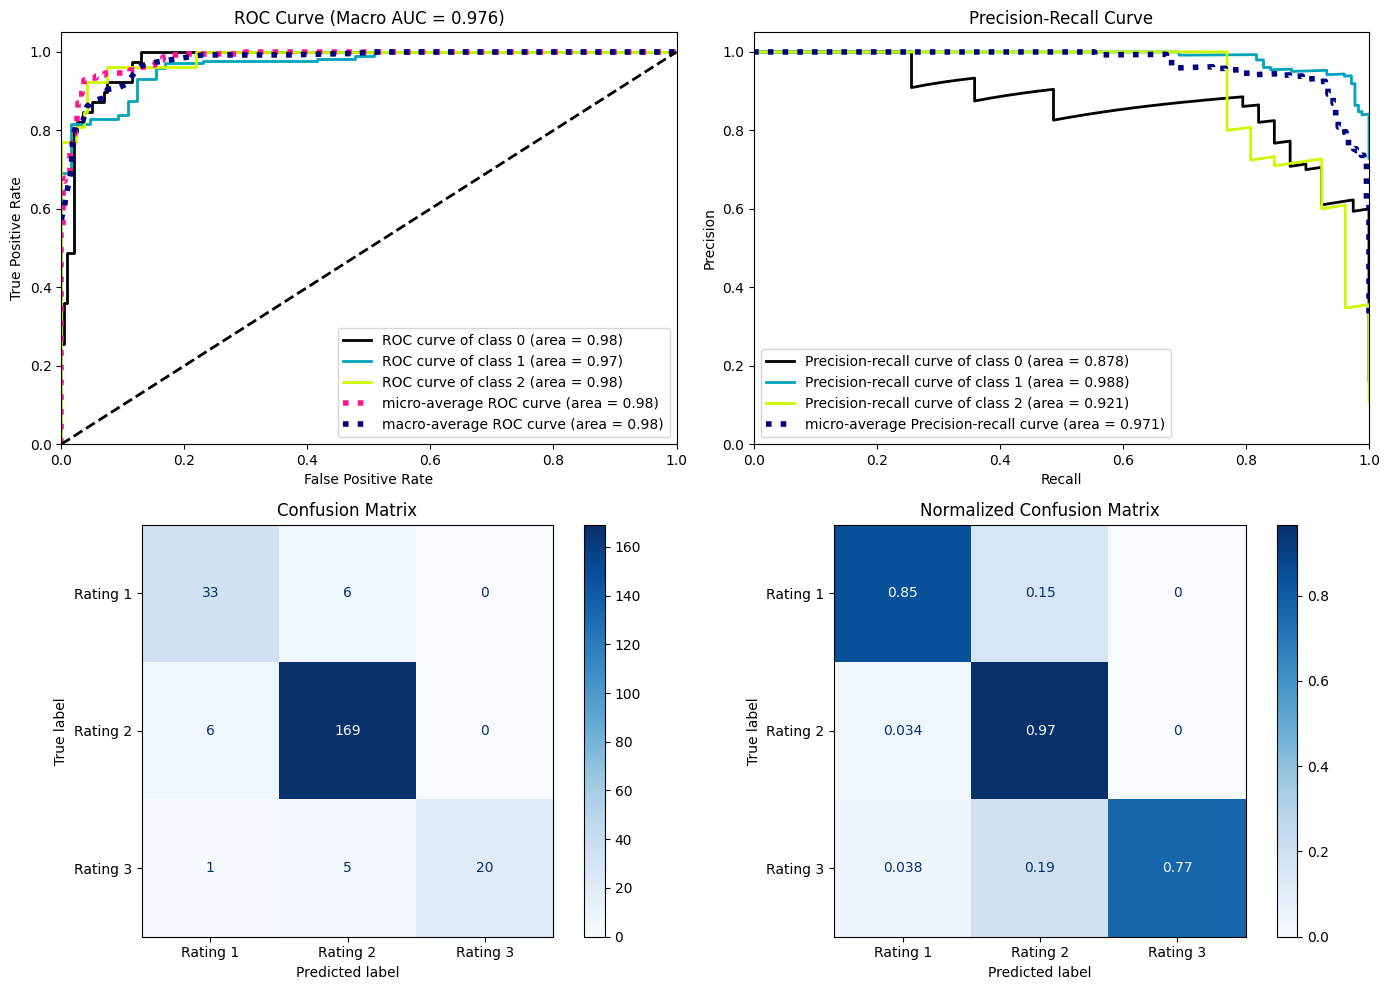

In [18]:
plot_multiclass_evaluation(final_model, X_test, y_test_mapped, class_labels=["Rating 1", "Rating 2", "Rating 3"])

 Model Evaluation Summary:

The final XGBoost model achieved impressive performance across various metrics. It had a training time of 0.779 seconds, and its accuracy was 92.5%. The model showed strong precision (92.7%) and recall (92.5%), which indicates balanced performance across both metrics. The F1-Score of 92.42% demonstrates that the model can effectively balance precision and recall, while the ROC AUC score of 0.9755 further confirms its ability to distinguish between classes.

Additionally, the model's performance in cross-validation was robust, with an average F1-Score of 93.32% across five folds and a standard deviation of 0.39%, suggesting consistent performance with minimal variance.

 Classification Report and Confusion Matrix:

- Classification Report: The classification report provides detailed insight into the model's performance for each class. It shows that:
  - Rating 1 had a precision of 82% and recall of 85%, with an F1-score of 84%.
  - Rating 2 performed the best with precision of 94% and recall of 97%, yielding a F1-score of 95%.
  - Rating 3 had perfect precision (100%) but a recall of 77%, resulting in a F1-score of 87%.

- Confusion Matrix: The confusion matrix shows the model's predictions:
  - Rating 1 had 33 correct predictions and 6 misclassifications.
  - Rating 2 had 169 correct predictions with only 6 misclassifications.
  - Rating 3 had 20 correct predictions and 6 misclassifications, showing some challenges in identifying this class.

 Evaluation Plots:

The ROC Curve and Precision-Recall Curve reveal that the model performs exceptionally well in terms of both accuracy and recall across the classes. The macro average ROC AUC score of 0.976 and macro average Precision-Recall AUC of 0.971 suggest that the model generalizes well across all classes. The curves for each class show strong performance, with class 0 (Rating 1) achieving an AUC of 0.98, class 1 (Rating 2) scoring 0.97, and class 2 (Rating 3) also reaching 0.98.

 Conclusion:

The final XGBoost model with balanced class weights has delivered solid performance across both training and test sets. It shows strong capabilities in multi-class classification, balancing precision, recall, and F1-score well. The cross-validation results and evaluation plots confirm that the model is robust, with minimal overfitting, and it handles class imbalances effectively.

---

### Saving the Model

In [19]:
import joblib
# Save the final trained model
joblib.dump(final_model, "XGBClassifier_model_multiclass.pkl")
print(" Model saved successfully!")

 Model saved successfully!


### Loading the Model Further use

In [20]:
# Load the trained model
final_model = joblib.load("XGBClassifier_model_multiclass.pkl")
# Predict the class labels on the test set
y_pred_final = final_model.predict(X_test)
# Show classification report
print("\n Classification Report (Multiclass):")
print(classification_report(y_test_mapped, y_pred_final, target_names=["Rating 1", "Rating 2", "Rating 3"]))


 Classification Report (Multiclass):
              precision    recall  f1-score   support

    Rating 1       0.82      0.85      0.84        39
    Rating 2       0.94      0.97      0.95       175
    Rating 3       1.00      0.77      0.87        26

    accuracy                           0.93       240
   macro avg       0.92      0.86      0.89       240
weighted avg       0.93      0.93      0.92       240



The model has been successfully saved using joblib and is now available for future use. After loading the saved model, we used it to predict the class labels on the test set.

Here is the classification report for the predictions:

Rating 1: Precision of 82%, Recall of 85%, and F1-Score of 84%.

Rating 2: Precision of 94%, Recall of 97%, and F1-Score of 95%.

Rating 3: Precision of 100%, Recall of 77%, and F1-Score of 87%.

Overall, the model achieved 93% accuracy on the test set, indicating solid performance. The macro average F1-score is 0.89, and the weighted average F1-score is 0.92, further demonstrating the model's effectiveness in handling multiple classes with an imbalance in the dataset.